# Dubins - Casadi

In [1]:
from os.path import exists
file_exists = exists('basic_material.py')

if (not file_exists):
    !wget -O basic_material.py https://www.dropbox.com/s/o48uhuwah8n2xww/basic_material.py?dl=0
%run basic_material

from casadi import *
from pylab import plot, step, figure, legend, show, spy

opts0 = {"ipopt.linear_solver":'ma27', "ipopt.tol":1e-3, "expand":False,'ipopt.print_level': 0, 'print_time': 0, 'ipopt.sb': 'yes'}

Running Python: 3.8.16


In [2]:
class Dubins():
    def __init__ (self):
        self.opti = None
        self.params = None
        self.sol = None

N = 200 # number of control intervals
# parameters
alp = 0.05 # cost penalty
L = 4  # wheel baseline
um_acc = 1.8
um_phi = 0.7
ar_max = 1
x0 = 0 # Terminal State - X0 = 0 
y0 = 0 # Terminal State - Y0 = 0
xf = 40 # Terminal State - X0 = 0 
yf = 40 # Terminal State - Y0 = 0
TH0 = atan((yf-y0)/(xf-x0)) # Initial angle
THf = np.pi*(45/180) # Final angle

V0 = 2.0
Vf = 1.0
X0=np.array([x0,y0,V0,TH0,xf,yf,Vf,THf])

Nobst = 1
obstx = np.array([20])
obsty = np.array([20])
obstR = np.array([6])
if 1:
    Nobst += 20
    obstx = np.append(obstx,np.random.randint(x0+10, xf-10, size=Nobst-1))
    obsty = np.append(obsty,np.random.randint(y0, yf, size=Nobst-1))
    obstR = np.append(obstR,np.random.randint(1, 5, size=Nobst-1)/5)

In [3]:
def deriv(x,u,t): 
    return vertcat(x[2]*cos(x[3]),    # dot x  
                   x[2]*sin(x[3]),    # dot y
                   u[0],              # dot V 
                   x[2]/L*tan(u[1]),  # dot theta 
                   1 + alp*(u[0]**2+u[1]**2)) # dot J

def create_opti(Dubins):
    opti = Opti() # Optimization problem
    # ---- decision variables ---------
    cX = opti.variable(5,N+1) # state trajectory
    cU = opti.variable(2,N)   # control trajectory (throttle)
    T = opti.variable()      # final time
    cx0 = cX[0,:] # x
    cx1 = cX[1,:] # y
    cx2 = cX[2,:] # V
    cx3 = cX[3,:] # theta
    cx4 = cX[4,:] # J
    acc = cU[0,:] # J
    phi = cU[1,:] # J

    # ---- objective          ---------
    opti.minimize(cx4[-1]) # race in minimal time

    # ---- dynamic constraints --------
    f = lambda x,u,t: deriv(x,u,t) # dx/dt = f(x,u)

    dt = T/N # length of a control interval
    for k in range(N-1): # loop over control intervals
        k1 = f(cX[:,k],         cU[:,k],k*dt)
        k2 = f(cX[:,k]+dt/2*k1, (cU[:,k]+cU[:,k+1])/2.0,(k+1/2)*dt)
        k3 = f(cX[:,k]+dt/2*k2, (cU[:,k]+cU[:,k+1])/2.0,(k+1/2)*dt)
        k4 = f(cX[:,k]+dt*k3,   cU[:,k+1],(k+1)*dt)
        x_next = cX[:,k] + dt/6*(k1+2*k2+2*k3+k4) 
        opti.subject_to(cX[:,k+1]==x_next) # close the gaps
    else:
        # now do the last step (no u(k+1))
        k = N-1
        k1 = f(cX[:,k],         cU[:,k],k*dt)
        k2 = f(cX[:,k]+dt/2*k1, cU[:,k],(k+1/2)*dt)
        k3 = f(cX[:,k]+dt/2*k2, cU[:,k],(k+1/2)*dt)
        k4 = f(cX[:,k]+dt*k3,   cU[:,k],(k+1)*dt)
        x_next = cX[:,k] + dt/6*(k1+2*k2+2*k3+k4) 
        opti.subject_to(cX[:,k+1]==x_next) # close the gaps

    # ---- boundary conditions --------
    p = opti.parameter(1,8)

    # ---- boundary conditions --------
    opti.subject_to(cx0[0]==p[0]) # x0 ...
    opti.subject_to(cx1[0]==p[1]) # y0 
    opti.subject_to(cx2[0]==p[2]) # V0 ...
    opti.subject_to(cx3[0]==p[3]) # theta0 
    opti.subject_to(cx4[0]==0) # J0 
    opti.subject_to(cx0[-1]==p[4])  # xf
    opti.subject_to(cx1[-1]==p[5])  # yf
    opti.subject_to(cx2[-1]==p[6])  # Vf
    opti.subject_to(cx3[-1]==p[7])  # thetaf

    opti.subject_to(opti.bounded(-ar_max,cx2[:-1]**2*sin(phi)/L,ar_max)) # control is limited
    opti.subject_to(opti.bounded(-um_acc,acc,um_acc)) # control is limited
    opti.subject_to(opti.bounded(-um_phi,phi,um_phi)) # control is limited
    opti.subject_to(T >= 0) # Time must be positive
    opti.subject_to(cx2 >= 0) # keep speed positive
    
    # obstacles
    for kk in range(Nobst):
        opti.subject_to((cx0-obstx[kk])**2+(cx1-obsty[kk])**2 >= obstR[kk]**2)   # track speed limit

    opti.solver('ipopt',opts0) # set numerical backend

    Dubins.params = p, T, cX, cU
    Dubins.opti = opti
    
    return Dubins

def min_casadi(X0,Dubins):
    if Dubins.opti is None:
        Dubins = create_opti(Dubins)

    p,T,cX,cU = Dubins.params
    
    if Dubins.sol is not None:
        Dubins.opti.set_initial(Dubins.sol.value_variables())

    for k in range(8):
        Dubins.opti.set_value(p[k],X0[k])

    # ---- initial values for solver ---
    Dubins.sol = Dubins.opti.solve()   # actual solve
    return Dubins 

In [4]:
Dubins.opti = None
Dubins.params = None
Dubins.sol = None
Dubins = min_casadi(X0,Dubins)
print('Optimization was a success: '+str(Dubins.sol.stats()['success']))

Optimization was a success: True


In [5]:
p,T,cX,cU = Dubins.params

Tf = Dubins.sol.value(T)
t = Tf*np.linspace(0, 1, N+1, endpoint=True)

x = Dubins.sol.value(cX)[0,:]
y = Dubins.sol.value(cX)[1,:]
V = Dubins.sol.value(cX)[2,:]
theta = Dubins.sol.value(cX)[3,:]
acc = Dubins.sol.value(cU)[0,:]
phi = Dubins.sol.value(cU)[1,:]

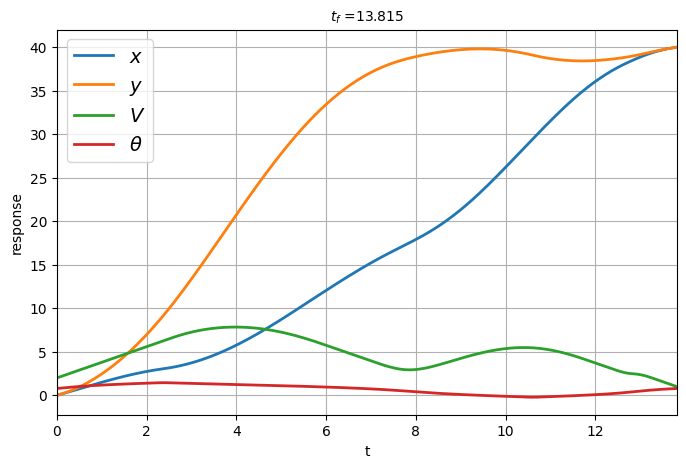

In [6]:
plt.figure(figsize = (8,5))
plt.plot(t,x,label="$x$")
plt.plot(t,y,label="$y$")
plt.plot(t,V,label="$V$")
plt.plot(t,theta,label=r"$\theta$")
plt.legend(loc="upper left")
plt.xlabel('t')
plt.title('$t_f$ ='+str(round(Tf,3)))
plt.ylabel('response')
plt.legend()
plt.legend(fontsize=14)
plt.xlim([0,Tf])
plt.savefig("figs/Dubins_casadi_1.png")
plt.show()

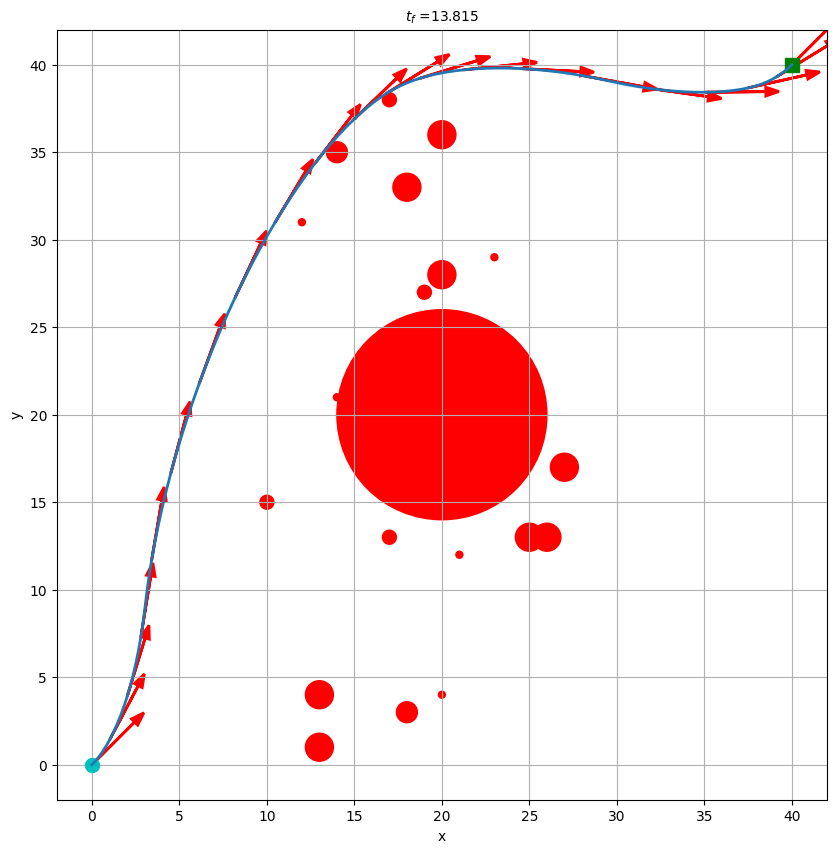

In [7]:
figure, axes = plt.subplots()
plt.plot(x0,y0,'co',ms=10)
plt.plot(xf,yf,'gs',ms=10)
plt.plot(x,y)
axes.set_aspect( 1 )
r1 = int(max(max(x),max(y)))+2
r0 = int(min(min(x),min(y)))-2
plt.xlim([r0,r1])
plt.ylim([r0,r1])

for kk in range(Nobst):
    Drawing_colored_circle = plt.Circle(( obstx[kk] , obsty[kk] ), obstR[kk],  color='r')
    axes.add_artist( Drawing_colored_circle )


for k in range(0,N+1,10):
    plt.arrow(x[k], y[k], .1*r1*np.cos(theta[k]), .1*r1*np.sin(theta[k]), shape='full', 
              lw=2, length_includes_head=True, head_width=.5, facecolor='r', edgecolor='r')

plt.xlabel('x')
plt.title('$t_f$ ='+str(round(Tf,3)))
plt.ylabel('y')
plt.savefig("figs/Dubins_casadi_2.png")
plt.show()

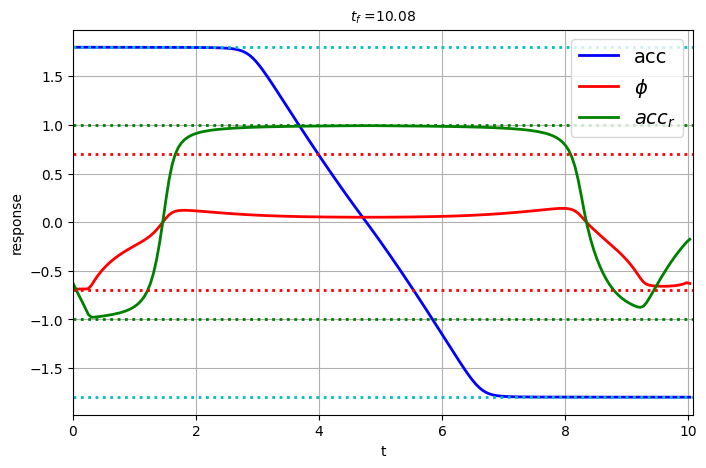

In [8]:
plt.figure(figsize = (8,5))
plt.plot(t[:-1],acc,'b',label="acc")
plt.plot(t[:-1],phi,'r',label="$\phi$")
plt.plot(t[:-1],V[:-1]**2*sin(phi)/L,'g',label="$acc_r$")
plt.plot([0, max(t)],[ar_max, ar_max],'g:')
plt.plot([0, max(t)],[-ar_max, -ar_max],'g:')
plt.plot([0, max(t)],[um_acc, um_acc],'c:')
plt.plot([0, max(t)],[-um_acc, -um_acc],'c:')
plt.plot([0, max(t)],[um_phi, um_phi],'r:')
plt.plot([0, max(t)],[-um_phi, -um_phi],'r:')
plt.legend(loc="upper left")
plt.xlabel('t')
plt.title('$t_f$ ='+str(round(Tf,3)))
plt.ylabel('response')
plt.legend()
plt.legend(fontsize=14)
plt.xlim([0,Tf])
plt.savefig("figs/Dubins_casadi_3.png")
plt.show()